In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# 1.Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)


In [ ]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
# !rm  images/*.mat

# 2.Generators

In [ ]:
mask = Image.open('/content/annotations/trimaps/Abyssinian_10.png')
mask = np.array(mask.resize((256, 256)))

mask[mask >= 2]
np.unique(mask)

array([1, 2, 3], dtype=uint8)

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [ ]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

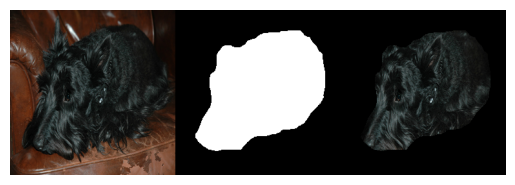

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# 3.IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# 4.Unet

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

## 4.1.Training

i= 1 loss= 0.5806283354759216 val_loss= 0.5656656622886658 mean_iou= 0.0019377865828573704 val_mean_iou= 0.0
1/1 [==============================] - 1s 966ms/step


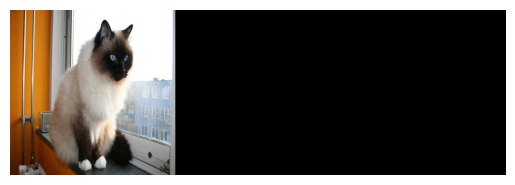

i= 2 loss= 0.5099661946296692 val_loss= 0.5193105340003967 mean_iou= 0.15047354996204376 val_mean_iou= 0.47225797176361084
1/1 [==============================] - 0s 31ms/step


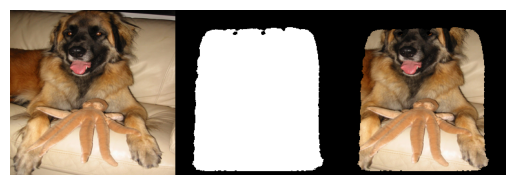

i= 3 loss= 0.4553453326225281 val_loss= 0.45556288957595825 mean_iou= 0.43424877524375916 val_mean_iou= 0.3782791793346405
1/1 [==============================] - 0s 22ms/step


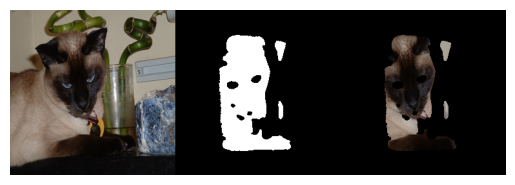

i= 4 loss= 0.42538559436798096 val_loss= 0.3823498487472534 mean_iou= 0.45846104621887207 val_mean_iou= 0.5364013314247131
1/1 [==============================] - 0s 21ms/step


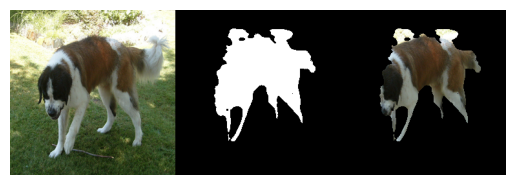

i= 5 loss= 0.3877592384815216 val_loss= 0.34290629625320435 mean_iou= 0.5076774954795837 val_mean_iou= 0.5170716643333435
1/1 [==============================] - 0s 21ms/step


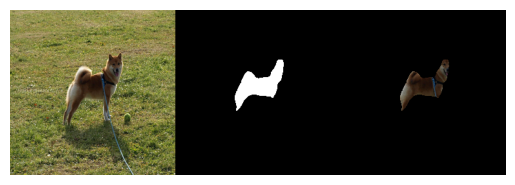

i= 6 loss= 0.35661575198173523 val_loss= 0.34935057163238525 mean_iou= 0.5625718235969543 val_mean_iou= 0.5891490578651428
1/1 [==============================] - 0s 23ms/step


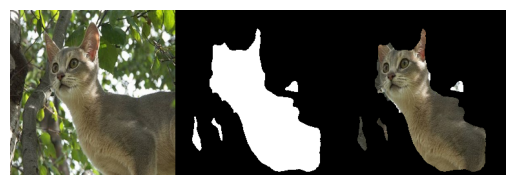

i= 7 loss= 0.3240126073360443 val_loss= 0.3253750205039978 mean_iou= 0.6040213108062744 val_mean_iou= 0.549623966217041
1/1 [==============================] - 0s 19ms/step


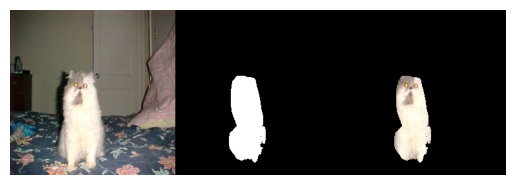

i= 8 loss= 0.2996797263622284 val_loss= 0.26888424158096313 mean_iou= 0.6375172138214111 val_mean_iou= 0.6807154417037964
1/1 [==============================] - 0s 21ms/step


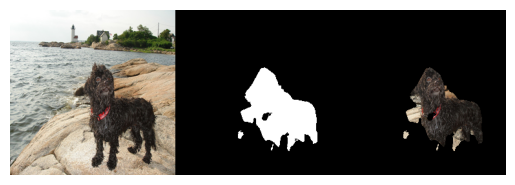

i= 9 loss= 0.2731638252735138 val_loss= 0.3067030906677246 mean_iou= 0.6646955609321594 val_mean_iou= 0.6833021640777588
1/1 [==============================] - 0s 21ms/step


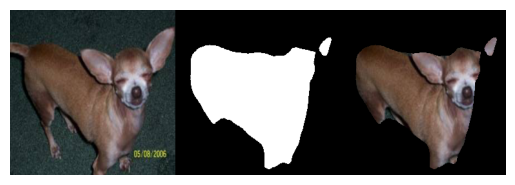

i= 10 loss= 0.2637985944747925 val_loss= 0.293071448802948 mean_iou= 0.6851351857185364 val_mean_iou= 0.605158805847168
1/1 [==============================] - 0s 21ms/step


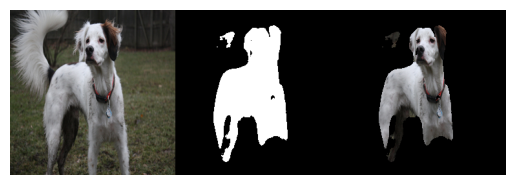

i= 11 loss= 0.24621042609214783 val_loss= 0.22726568579673767 mean_iou= 0.7047533988952637 val_mean_iou= 0.71198570728302
1/1 [==============================] - 0s 19ms/step


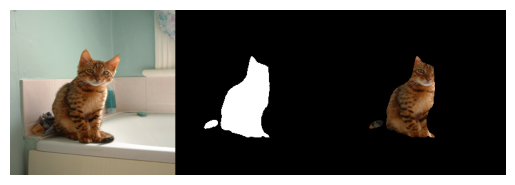

i= 12 loss= 0.2386114001274109 val_loss= 0.3146337568759918 mean_iou= 0.7150846123695374 val_mean_iou= 0.6645383238792419
1/1 [==============================] - 0s 20ms/step


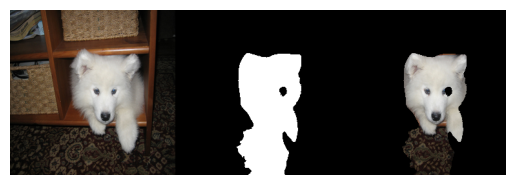

i= 13 loss= 0.22169733047485352 val_loss= 0.30485016107559204 mean_iou= 0.7355890870094299 val_mean_iou= 0.6266884207725525
1/1 [==============================] - 0s 21ms/step


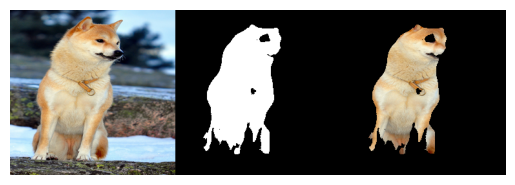

i= 14 loss= 0.20678000152111053 val_loss= 0.24541829526424408 mean_iou= 0.7489540576934814 val_mean_iou= 0.7149616479873657
1/1 [==============================] - 0s 20ms/step


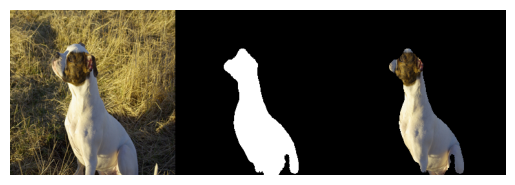

i= 15 loss= 0.20049111545085907 val_loss= 0.2565251290798187 mean_iou= 0.7612918615341187 val_mean_iou= 0.7252963185310364
1/1 [==============================] - 0s 35ms/step


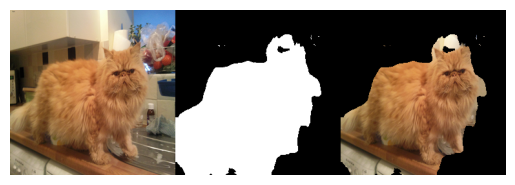

i= 16 loss= 0.18745528161525726 val_loss= 0.20699986815452576 mean_iou= 0.7698049545288086 val_mean_iou= 0.7604030966758728
1/1 [==============================] - 0s 23ms/step


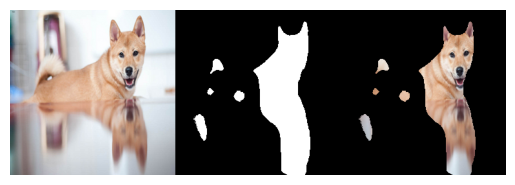

i= 17 loss= 0.1801329106092453 val_loss= 0.20372284948825836 mean_iou= 0.7830591797828674 val_mean_iou= 0.7537813186645508
1/1 [==============================] - 0s 20ms/step


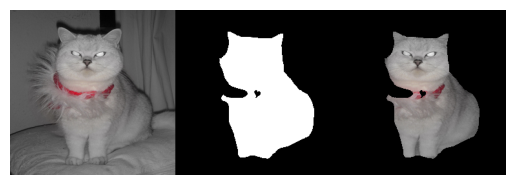

i= 18 loss= 0.1755117028951645 val_loss= 0.1974826455116272 mean_iou= 0.7860270738601685 val_mean_iou= 0.7689252495765686
1/1 [==============================] - 0s 20ms/step


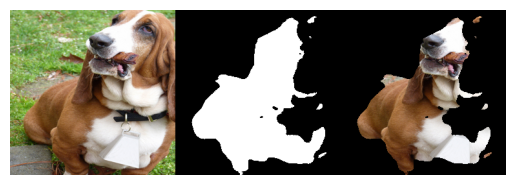

i= 19 loss= 0.16774235665798187 val_loss= 0.18725919723510742 mean_iou= 0.7966629266738892 val_mean_iou= 0.775531530380249
1/1 [==============================] - 0s 23ms/step


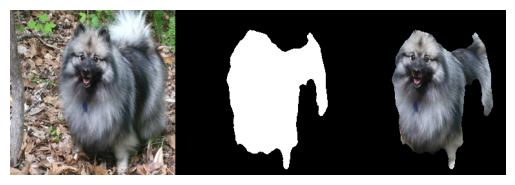

i= 20 loss= 0.1566469520330429 val_loss= 0.24185778200626373 mean_iou= 0.8077953457832336 val_mean_iou= 0.7220960855484009
1/1 [==============================] - 0s 24ms/step


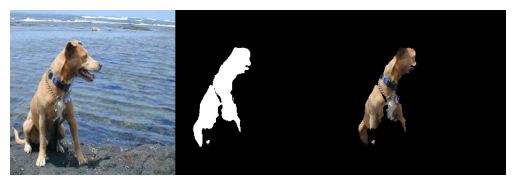

i= 21 loss= 0.15219536423683167 val_loss= 0.21434497833251953 mean_iou= 0.8132128715515137 val_mean_iou= 0.7483718395233154
1/1 [==============================] - 0s 29ms/step


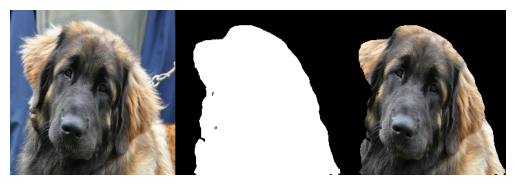

i= 22 loss= 0.14843161404132843 val_loss= 0.1984976828098297 mean_iou= 0.8183932304382324 val_mean_iou= 0.7595862746238708
1/1 [==============================] - 0s 25ms/step


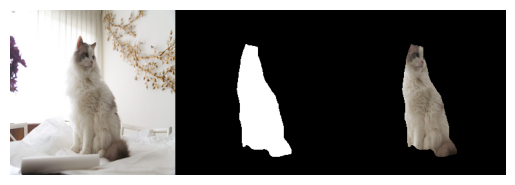

i= 23 loss= 0.14262990653514862 val_loss= 0.2047768086194992 mean_iou= 0.8221637606620789 val_mean_iou= 0.7666588425636292
1/1 [==============================] - 0s 20ms/step


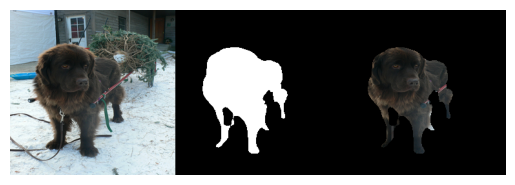

i= 24 loss= 0.13762833178043365 val_loss= 0.20170918107032776 mean_iou= 0.8289555311203003 val_mean_iou= 0.7506014108657837
1/1 [==============================] - 0s 20ms/step


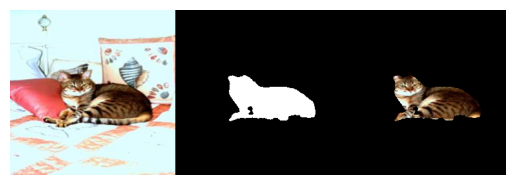

i= 25 loss= 0.13256816565990448 val_loss= 0.19870524108409882 mean_iou= 0.8367011547088623 val_mean_iou= 0.7760574817657471
1/1 [==============================] - 0s 20ms/step


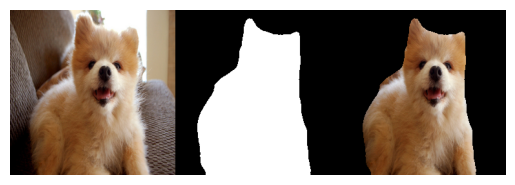

i= 26 loss= 0.12806861102581024 val_loss= 0.19009165465831757 mean_iou= 0.8400533199310303 val_mean_iou= 0.7884469628334045
1/1 [==============================] - 0s 19ms/step


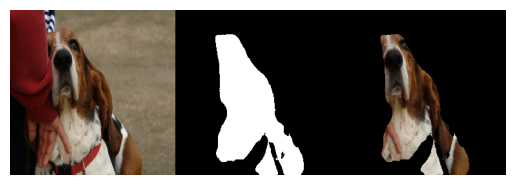

i= 27 loss= 0.12052031606435776 val_loss= 0.30500584840774536 mean_iou= 0.8483009934425354 val_mean_iou= 0.7099819183349609
1/1 [==============================] - 0s 19ms/step


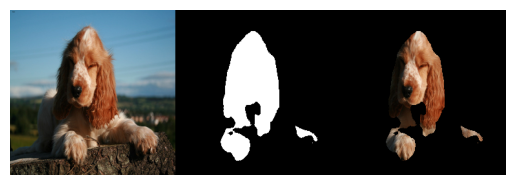

i= 28 loss= 0.11874228715896606 val_loss= 0.21241158246994019 mean_iou= 0.8494633436203003 val_mean_iou= 0.7749549746513367
1/1 [==============================] - 0s 21ms/step


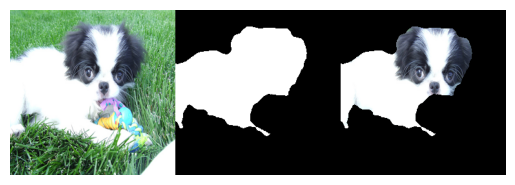

i= 29 loss= 0.11428812891244888 val_loss= 0.19978956878185272 mean_iou= 0.855539858341217 val_mean_iou= 0.7867641448974609
1/1 [==============================] - 0s 23ms/step


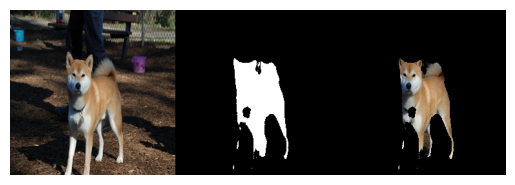

i= 30 loss= 0.10821285843849182 val_loss= 0.2051692008972168 mean_iou= 0.8592262864112854 val_mean_iou= 0.7879175543785095
1/1 [==============================] - 0s 23ms/step


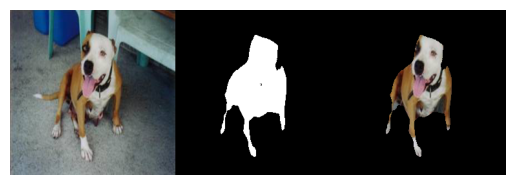

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, epochs = 30, steps_per_epoch = train_steps,
          validation_data = test_generator, validation_steps = test_steps, 
          callbacks = build_callbacks(), verbose = 0)

## 4.2.Testing

In [ ]:
!wget https://traichopoodle.com/wp-content/uploads/2017/09/toy-poodle-nau-do.jpg -O test.jpg

--2023-05-22 04:00:09--  https://traichopoodle.com/wp-content/uploads/2017/09/toy-poodle-nau-do.jpg
Resolving traichopoodle.com (traichopoodle.com)... 202.92.5.50
Connecting to traichopoodle.com (traichopoodle.com)|202.92.5.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47019 (46K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  45.92K   123KB/s    in 0.4s    

2023-05-22 04:00:11 (123 KB/s) - ‘test.jpg’ saved [47019/47019]



1/1 [==============================] - 0s 21ms/step


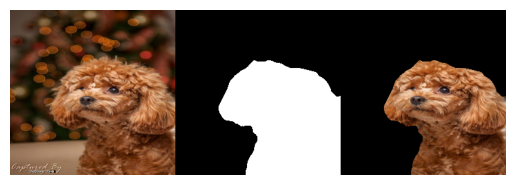

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# 5.FCN

In [ ]:
def FCN(sz=(256, 256, 3)):
  inputs = keras.Input(shape=sz)
  x = keras.layers.Dense(100, activation=tf.nn.relu)(inputs)
  x = keras.layers.Dense(50, activation=tf.nn.relu)(x)
  outputs = keras.layers.Dense(1, activation=tf.nn.softmax)(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [ ]:
FCN_model = FCN()

## 5.1.Training

i= 1 loss= 10.758162498474121 val_loss= 10.681705474853516 mean_iou= 0.29451149702072144 val_mean_iou= 0.29952535033226013
1/1 [==============================] - 0s 20ms/step


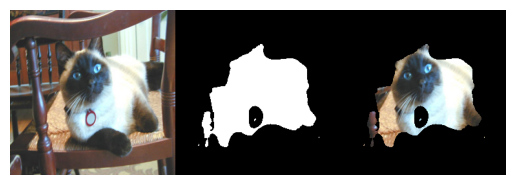

i= 2 loss= 10.718512535095215 val_loss= 10.656052589416504 mean_iou= 0.2971113622188568 val_mean_iou= 0.3012075424194336
1/1 [==============================] - 0s 24ms/step


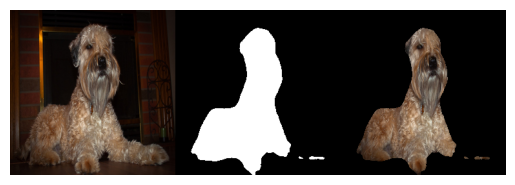

i= 3 loss= 10.723954200744629 val_loss= 10.714753150939941 mean_iou= 0.2967548370361328 val_mean_iou= 0.29735812544822693
1/1 [==============================] - 0s 20ms/step


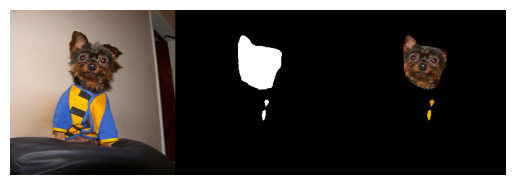

i= 4 loss= 10.752349853515625 val_loss= 10.703644752502441 mean_iou= 0.29489263892173767 val_mean_iou= 0.29808661341667175
1/1 [==============================] - 0s 20ms/step


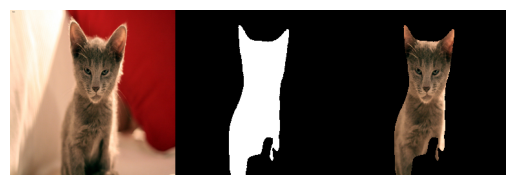

i= 5 loss= 10.700089454650879 val_loss= 10.562732696533203 mean_iou= 0.2983197569847107 val_mean_iou= 0.3073272407054901
1/1 [==============================] - 0s 30ms/step


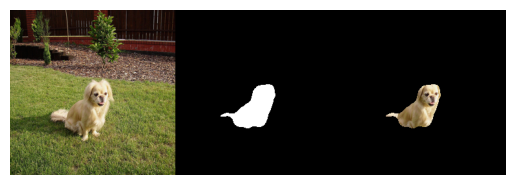

i= 6 loss= 10.763580322265625 val_loss= 10.8775053024292 mean_iou= 0.2941560447216034 val_mean_iou= 0.2866852879524231
1/1 [==============================] - 0s 20ms/step


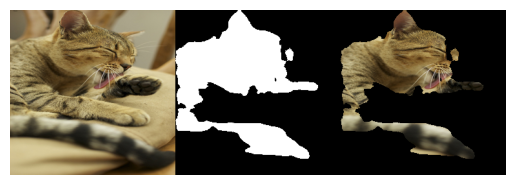

i= 7 loss= 10.702964782714844 val_loss= 10.508333206176758 mean_iou= 0.29813140630722046 val_mean_iou= 0.31089457869529724
1/1 [==============================] - 0s 20ms/step


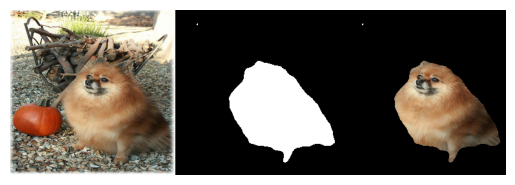

i= 8 loss= 10.6754789352417 val_loss= 10.558087348937988 mean_iou= 0.2999334931373596 val_mean_iou= 0.30763179063796997
1/1 [==============================] - 0s 20ms/step


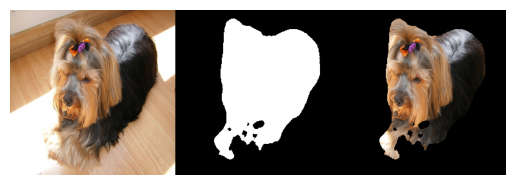

i= 9 loss= 10.743707656860352 val_loss= 10.67055892944336 mean_iou= 0.29545947909355164 val_mean_iou= 0.30025625228881836
1/1 [==============================] - 0s 21ms/step


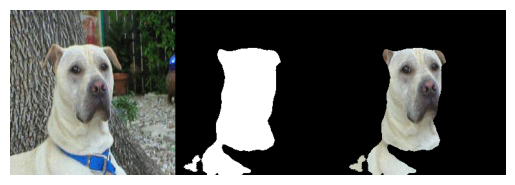

i= 10 loss= 10.75402545928955 val_loss= 10.41369342803955 mean_iou= 0.294782817363739 val_mean_iou= 0.31710079312324524
1/1 [==============================] - 0s 20ms/step


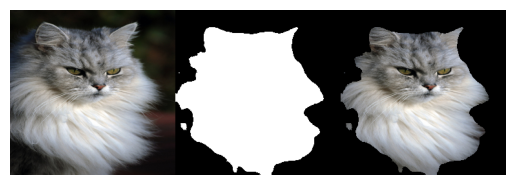

i= 11 loss= 10.705845832824707 val_loss= 10.943625450134277 mean_iou= 0.29794207215309143 val_mean_iou= 0.2823493778705597
1/1 [==============================] - 0s 26ms/step


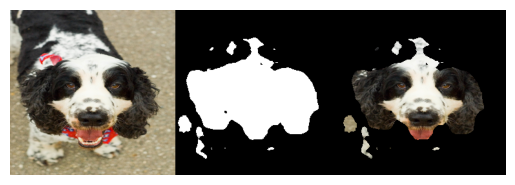

i= 12 loss= 10.651045799255371 val_loss= 10.612958908081055 mean_iou= 0.3015359938144684 val_mean_iou= 0.304033488035202
1/1 [==============================] - 0s 28ms/step


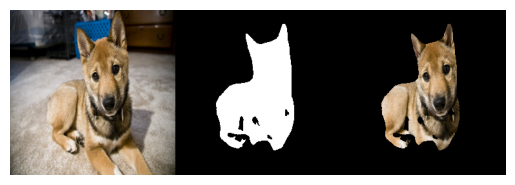

i= 13 loss= 10.674784660339355 val_loss= 10.596437454223633 mean_iou= 0.2999793291091919 val_mean_iou= 0.3051169514656067
1/1 [==============================] - 0s 20ms/step


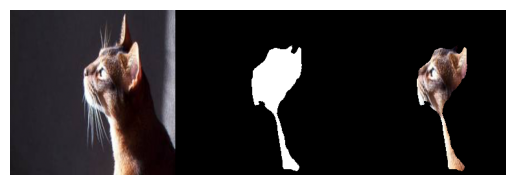

i= 14 loss= 10.709596633911133 val_loss= 10.659870147705078 mean_iou= 0.297696053981781 val_mean_iou= 0.30095717310905457
1/1 [==============================] - 0s 26ms/step


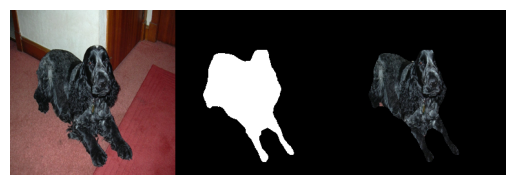

i= 15 loss= 10.717877388000488 val_loss= 10.540306091308594 mean_iou= 0.2971533536911011 val_mean_iou= 0.3087978661060333
1/1 [==============================] - 0s 23ms/step


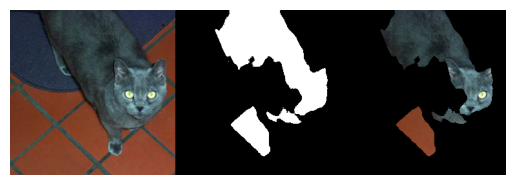

i= 16 loss= 10.695697784423828 val_loss= 10.780357360839844 mean_iou= 0.29860734939575195 val_mean_iou= 0.29305604100227356
1/1 [==============================] - 0s 20ms/step


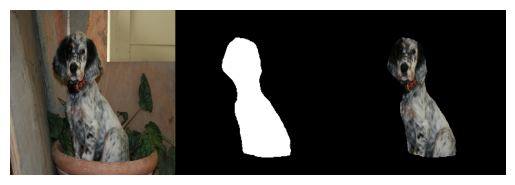

i= 17 loss= 10.743888854980469 val_loss= 10.762157440185547 mean_iou= 0.2954474687576294 val_mean_iou= 0.2942495346069336
1/1 [==============================] - 0s 22ms/step


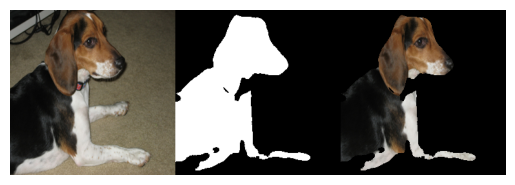

i= 18 loss= 10.723329544067383 val_loss= 10.620814323425293 mean_iou= 0.2967955768108368 val_mean_iou= 0.3035183250904083
1/1 [==============================] - 0s 28ms/step


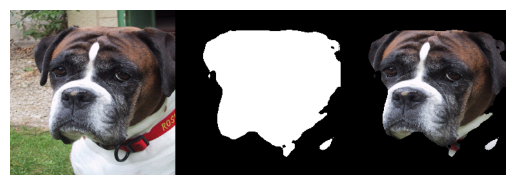

i= 19 loss= 10.692525863647461 val_loss= 10.653461456298828 mean_iou= 0.29881587624549866 val_mean_iou= 0.30137741565704346
1/1 [==============================] - 0s 20ms/step


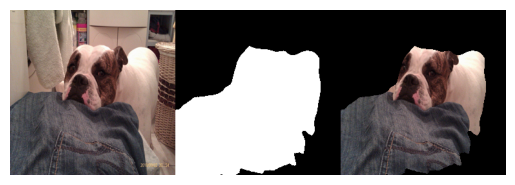

i= 20 loss= 10.734204292297363 val_loss= 10.782242774963379 mean_iou= 0.2960822880268097 val_mean_iou= 0.29293233156204224
1/1 [==============================] - 0s 19ms/step


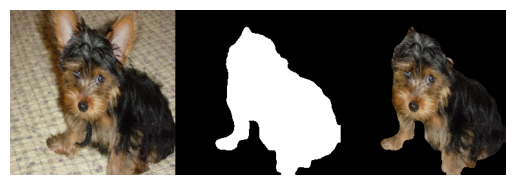

i= 21 loss= 10.712823867797852 val_loss= 10.5984468460083 mean_iou= 0.29748496413230896 val_mean_iou= 0.3049851357936859
1/1 [==============================] - 0s 19ms/step


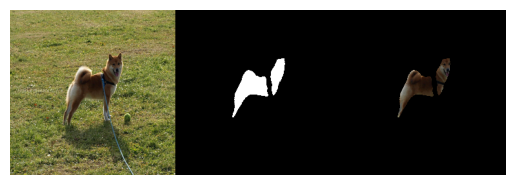

i= 22 loss= 10.78764533996582 val_loss= 10.413515090942383 mean_iou= 0.2925781309604645 val_mean_iou= 0.31711241602897644
1/1 [==============================] - 0s 29ms/step


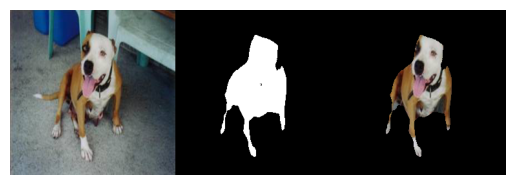

i= 23 loss= 10.723323822021484 val_loss= 10.854523658752441 mean_iou= 0.29679638147354126 val_mean_iou= 0.28819239139556885
1/1 [==============================] - 0s 23ms/step


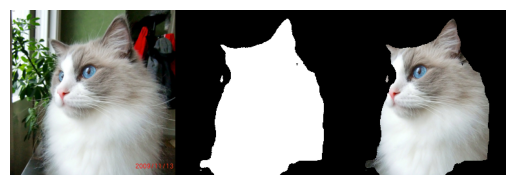

i= 24 loss= 10.751519203186035 val_loss= 10.71207046508789 mean_iou= 0.2949471175670624 val_mean_iou= 0.2975340783596039
1/1 [==============================] - 0s 19ms/step


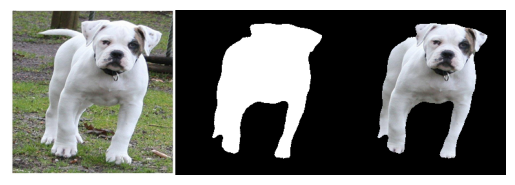

i= 25 loss= 10.695637702941895 val_loss= 10.549251556396484 mean_iou= 0.29861167073249817 val_mean_iou= 0.30821123719215393
1/1 [==============================] - 0s 20ms/step


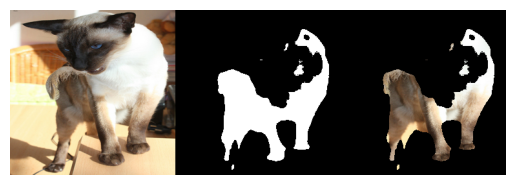

i= 26 loss= 10.78412914276123 val_loss= 10.759589195251465 mean_iou= 0.29280856251716614 val_mean_iou= 0.29441794753074646
1/1 [==============================] - 0s 32ms/step


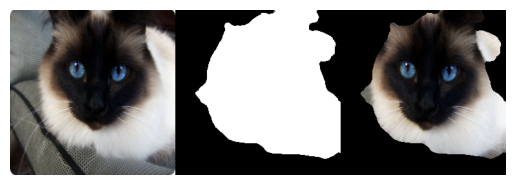

i= 27 loss= 10.726356506347656 val_loss= 10.540637969970703 mean_iou= 0.29659754037857056 val_mean_iou= 0.3087761104106903
1/1 [==============================] - 0s 28ms/step


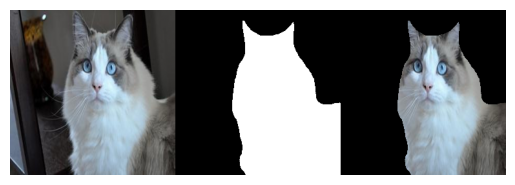

i= 28 loss= 10.713425636291504 val_loss= 10.666204452514648 mean_iou= 0.2974453270435333 val_mean_iou= 0.30054184794425964
1/1 [==============================] - 0s 20ms/step


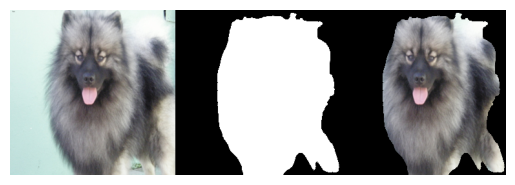

i= 29 loss= 10.699843406677246 val_loss= 10.450349807739258 mean_iou= 0.2983359396457672 val_mean_iou= 0.31469690799713135
1/1 [==============================] - 0s 20ms/step


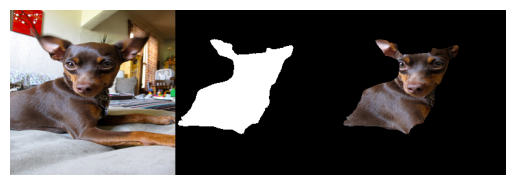

i= 30 loss= 10.734258651733398 val_loss= 10.714336395263672 mean_iou= 0.29607918858528137 val_mean_iou= 0.29738542437553406
1/1 [==============================] - 0s 19ms/step


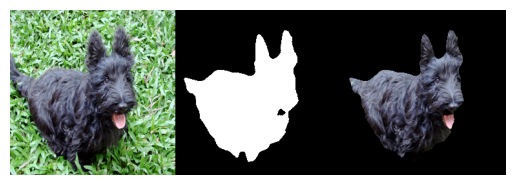

In [ ]:
FCN_model.fit(train_generator, epochs = 30, steps_per_epoch = train_steps,
          validation_data = test_generator, validation_steps = test_steps, 
          callbacks = build_callbacks(), verbose=0)

## 5.2.Testing

1/1 [==============================] - 0s 23ms/step


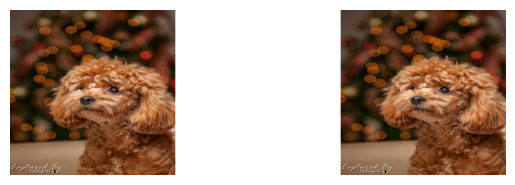

In [ ]:
#predict the mask 
pred = FCN_model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()